In [ ]:
!pip install keras

In [ ]:
!pip install scikit-learn

#-----------------------------------------------------------


**Importando as bibliotecas**

In [ ]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


**Carregar e Preparar o Dataset**

In [ ]:
data = pd.read_csv('PETR4.csv')

# Converter a coluna Date para o tipo datetime
data['Date'] = pd.to_datetime(data['Date'])

# Selecionar apenas a coluna 'Close' para previsão
data = data[['Date', 'Close']].set_index('Date')

# Normalizar os dados para que fiquem entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Mostrar as primeiras linhas dos dados
data.head()


,Close
Date,
2014-01-27,15.11
2014-01-28,15.05
2014-01-29,14.80
2014-01-30,14.70
2014-01-31,14.70


**Criar Conjuntos de Treinamento e Teste**

In [ ]:
# Definir o tamanho da janela (look-back)
look_back = 90  # Usar os últimos 90 dias para previsão

# Criar sequências de dados para a RNN
def create_dataset(data, look_back=1):
    # Inicializa listas vazias para armazenar os dados de entrada (X) e saída (y)
    X, y = [], []

    # Itera sobre o conjunto de dados, parando antes do comprimento total menos o look_back
    for i in range(len(data) - look_back):
        # Adiciona uma janela de dados de entrada à lista X
        # O slice data[i:(i + look_back), 0] pega os dados desde o índice i até i + look_back; o valor 0 indica a coluna
        X.append(data[i:(i + look_back), 0])  # Dados de entrada

        # Adiciona o próximo valor (o que segue a janela de entrada) à lista y
        # O índice i + look_back se refere ao valor que queremos prever
        y.append(data[i + look_back, 0])      # Dados de saída

    # Converte as listas X e y em arrays NumPy e retorna
    return np.array(X), np.array(y)


# Criar os conjuntos de dados
X, y = create_dataset(scaled_data, look_back)

# Redimensionar os dados para [amostras, passos do tempo, características]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir em conjunto de treinamento e teste (80% para treinamento, 20% para teste)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Mostrar a forma dos conjuntos de dados
#(número de linhas,número de passos de tempo ou o look-back, número de colunas)
print(f'Treinamento: {X_train.shape}, Teste: {X_test.shape}')


Treinamento: (922, 90, 1), Teste: (231, 90, 1)


**Construir a Rede Neural Recorrente (RNN)**

In [ ]:
# Criar o modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Primeira camada LSTM
model.add(Dropout(0.2))  # Camada Dropout para evitar overfitting
model.add(LSTM(50, return_sequences=False))  # Segunda camada LSTM
model.add(Dropout(0.2))  # Camada Dropout
model.add(Dense(1))  # Camada de saída para previsão do preço

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Mostrar a arquitetura do modelo
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 90, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

**Treinar a RNN**

In [ ]:
# Treinar o modelo
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Salvar o modelo se desejar
# model.save('modelo_acoes.h5')


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0651
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0048
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024
Epoch 13/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024
Epoch 14/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024
Epoch 15/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - lo

**Fazer Previsões**

In [ ]:
# Prever o próximo valor
last_data = scaled_data[-look_back:].reshape(1, look_back, 1)  # Últimos 90 dias para previsão
predicted_price = model.predict(last_data)  # Fazer a previsão

# Inverter a normalização para obter o preço real
predicted_price = scaler.inverse_transform(predicted_price)
print(f'Preço previsto para o dia seguinte: {predicted_price[0][0]:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Preço previsto para o dia seguinte: 24.91


**Avaliação do Modelo (opcional)**

In [ ]:
# Fazer previsões no conjunto de teste
predictions = model.predict(X_test)

# Inverter a normalização das previsões
predictions = scaler.inverse_transform(predictions)

# Calcular RMSE
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(y_test.reshape(-1, 1)))))
print(f'Root Mean Squared Error: {rmse:.2f}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Root Mean Squared Error: 0.83


In [ ]:
# Prever as três próximas amostras
predicted_prices = []

# Usar os últimos 90 dias para começar
last_data = scaled_data[-look_back:].reshape(1, look_back, 1)

for _ in range(3):  # Prever 3 dias
    predicted_price = model.predict(last_data)  # Fazer a previsão
    predicted_prices.append(predicted_price[0][0])  # Armazenar a previsão

    # Atualizar last_data para incluir a nova previsão
    last_data = np.append(last_data[:, 1:, :], predicted_price.reshape(1, 1, 1), axis=1)

# Inverter a normalização para obter os preços reais
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Mostrar os preços previstos para os próximos 3 dias
for i, price in enumerate(predicted_prices, start=1):
    print(f'Preço previsto para o dia {i} a partir de 2020-01-24: {price[0]:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Preço previsto para o dia 1 a partir de 2020-01-24: 24.91
Preço previsto para o dia 2 a partir de 2020-01-24: 24.58
Preço previsto para o dia 3 a partir de 2020-01-24: 24.15


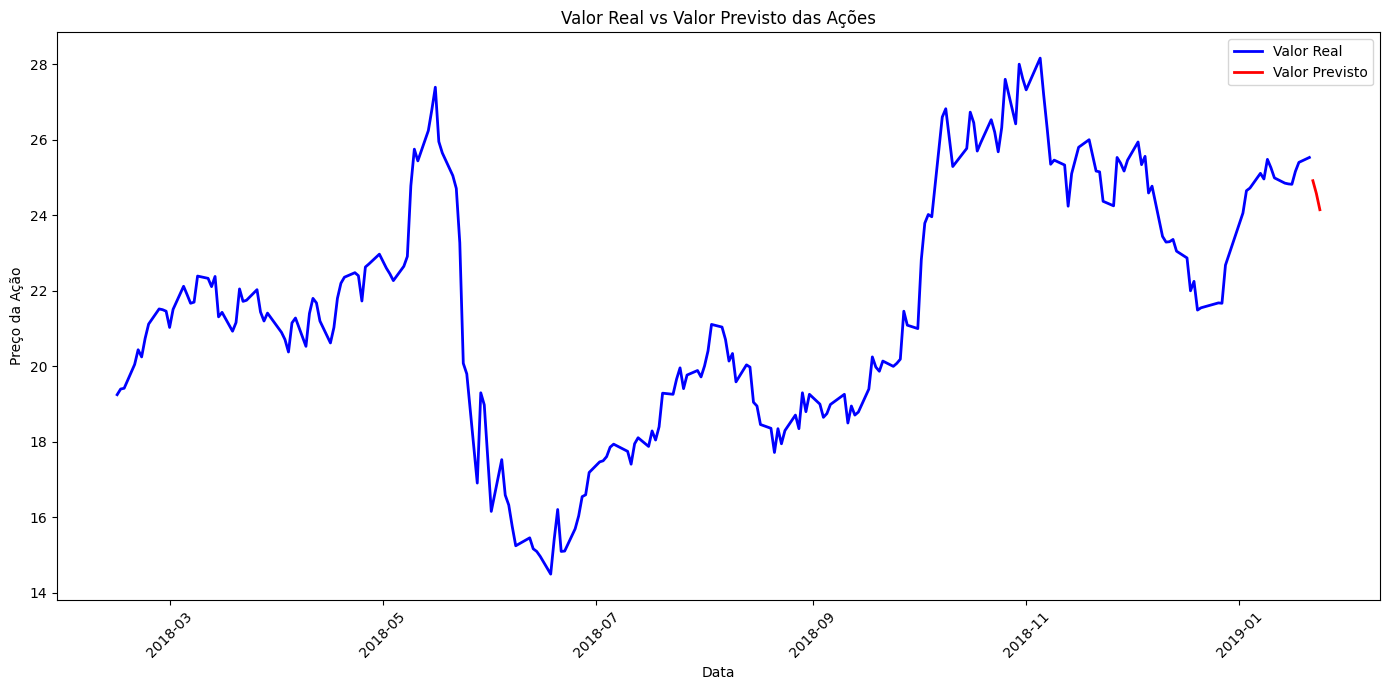

In [ ]:
# Plotar o gráfico dos valores reais e previstos

# Criar um DataFrame com os dados reais
real_prices = data['Close'].values[-(len(y_test) + 3):]  # Inclui os últimos valores reais + 3 previsões

# Concatenar as previsões com os preços previstos para os próximos 3 dias
predicted_prices_full = np.concatenate([predictions.flatten(), predicted_prices.flatten()])

# Criar o índice para os dias
dates = data.index[-(len(y_test) + 3):]  # Últimos índices

# Plotar
plt.figure(figsize=(14, 7))
plt.plot(dates[:len(y_test)], real_prices[:len(y_test)], color='blue', label='Valor Real', linewidth=2)
plt.plot(dates[len(y_test):], predicted_prices_full[len(y_test):], color='red', label='Valor Previsto', linewidth=2)
plt.title('Valor Real vs Valor Previsto das Ações')
plt.xlabel('Data')
plt.ylabel('Preço da Ação')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Média das previsões: R$24.55
Média real: R$21.65


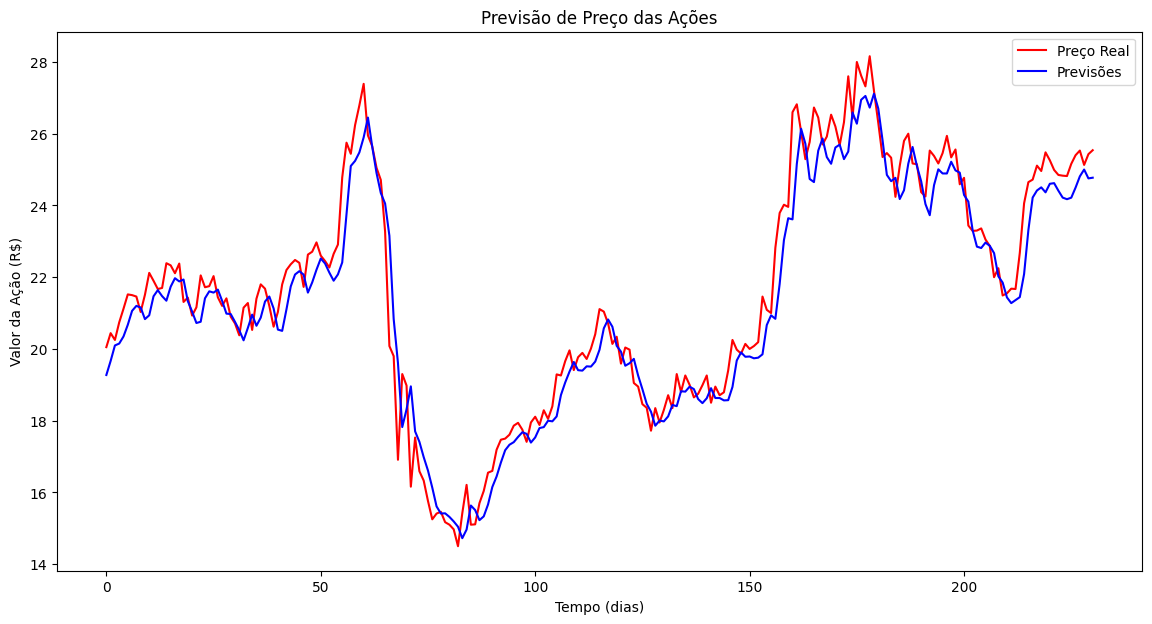

In [ ]:
# Calcular médias
media_previsoes = predicted_prices.flatten().mean()
media_real = scaler.inverse_transform(y_test.reshape(-1, 1)).mean()

print(f"Média das previsões: R${media_previsoes:.2f}")
print(f"Média real: R${media_real:.2f}")

# Plotar gráfico
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), color='red', label='Preço Real')  # Preços reais
plt.plot(predictions, color='blue', label='Previsões')  # Previsões do conjunto de teste
plt.title('Previsão de Preço das Ações')
plt.xlabel('Tempo (dias)')
plt.ylabel('Valor da Ação (R$)')
plt.legend()
plt.show()


**Refazendo sem normalizar**

In [ ]:
# Carregar o dataset (substitua 'dados_acoes.csv' pelo caminho do seu arquivo)
data = pd.read_csv('/home/PETR4.csv')

# Converter a coluna Date para o tipo datetime
data['Date'] = pd.to_datetime(data['Date'])

# Selecionar apenas a coluna 'Close' para previsão
data = data[['Date', 'Close']].set_index('Date')

# Mostrar as primeiras linhas dos dados
data.head()


,Close
Date,
2014-01-27,15.11
2014-01-28,15.05
2014-01-29,14.80
2014-01-30,14.70
2014-01-31,14.70


In [ ]:
# Definir o tamanho da janela (look-back)
look_back = 90  # Usar os últimos 90 dias para previsão

# Criar sequências de dados para a RNN
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])  # Dados de entrada
        y.append(data[i + look_back])        # Dados de saída
    return np.array(X), np.array(y)

# Criar os conjuntos de dados
X, y = create_dataset(data['Close'].values, look_back)

# Redimensionar os dados para [amostras, passos do tempo, características]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir em conjunto de treinamento e teste (80% para treinamento, 20% para teste)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Mostrar a forma dos conjuntos de dados
print(f'Treinamento: {X_train.shape}, Teste: {X_test.shape}')


Treinamento: (922, 90, 1), Teste: (231, 90, 1)


In [ ]:
# Criar o modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Primeira camada LSTM
model.add(Dropout(0.2))  # Camada Dropout para evitar overfitting
model.add(LSTM(50, return_sequences=False))  # Segunda camada LSTM
model.add(Dropout(0.2))  # Camada Dropout
model.add(Dense(1))  # Camada de saída para previsão do preço

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Mostrar a arquitetura do modelo
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 90, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 90, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Treinar o modelo
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Salvar o modelo se desejar
# model.save('modelo_acoes.h5')


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 131.0590
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 54.7883
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 30.5671
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22.7471
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.4138
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.0320
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.9370
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.6456
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.2471
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.0403
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4923
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.2615
Epoch 13/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6783
Epoch 14/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.0278
Epoch 15/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - los

In [ ]:
# Fazer previsões no conjunto de teste
predictions = model.predict(X_test)

# Prever os próximos 3 dias
predicted_prices = []

# Usar os últimos 90 dias para começar
last_data = data['Close'].values[-look_back:]

for _ in range(3):  # Prever 3 dias
    last_data_reshaped = last_data.reshape(1, look_back, 1)
    predicted_price = model.predict(last_data_reshaped)  # Fazer a previsão
    predicted_prices.append(predicted_price[0][0])  # Armazenar a previsão

    # Atualizar last_data para incluir a nova previsão
    last_data = np.append(last_data[1:], predicted_price)  # Remover o primeiro valor e adicionar a previsão

# Mostrar previsões
predicted_prices = np.array(predicted_prices)
print("Previsões para os próximos 3 dias:", predicted_prices)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Previsões para os próximos 3 dias: [22.206694 22.11159  21.963902]


Média das previsões: R$22.09
Média real: R$21.65


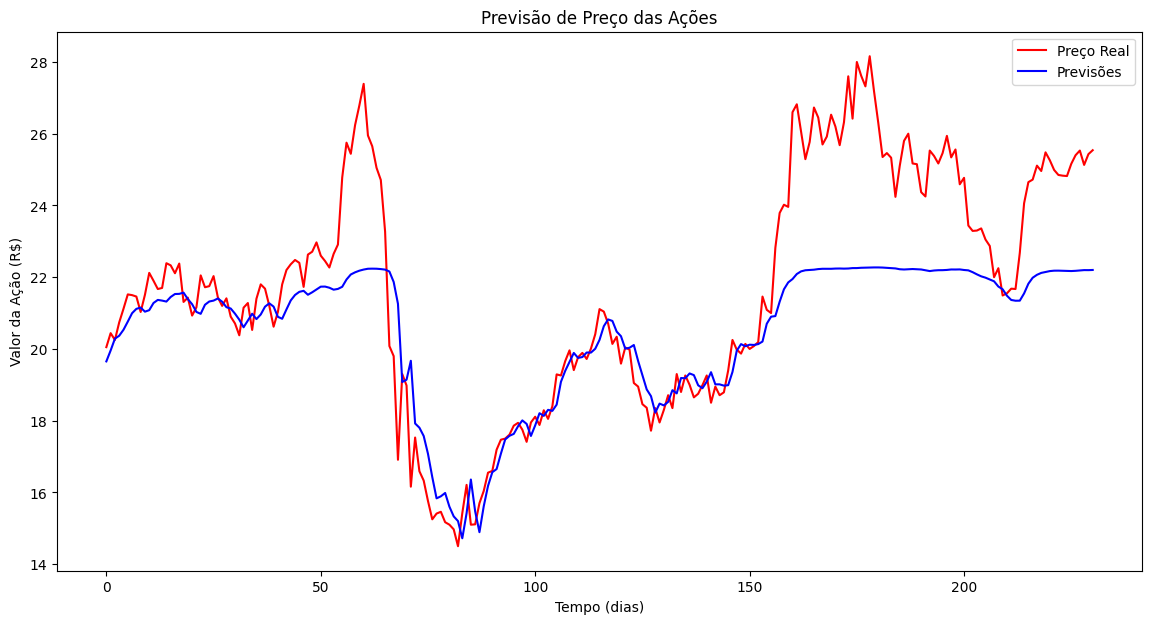

In [ ]:
# Calcular médias
media_previsoes = predicted_prices.mean()
media_real = y_test.mean()

print(f"Média das previsões: R${media_previsoes:.2f}")
print(f"Média real: R${media_real:.2f}")

# Plotar gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, color='red', label='Preço Real')  # Preços reais
plt.plot(predictions, color='blue', label='Previsões')  # Previsões do conjunto de teste
plt.title('Previsão de Preço das Ações')
plt.xlabel('Tempo (dias)')
plt.ylabel('Valor da Ação (R$)')
plt.legend()
plt.show()
